# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [22]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import random as rn
import datetime
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from PIL import Image, ImageFilter, ImageEnhance

We set the random seed so that the results don't vary drastically.

In [23]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [24]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [25]:
train_doc, val_doc = get_data('Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [47]:
def apply_augmentation(image, aug_type):
    """
    Applies the specified augmentation to the image.
    """
    if aug_type == 0:  # Edge Enhancement
        return np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
    elif aug_type == 1:  # Gaussian Blur
        return np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.GaussianBlur(1)))
    elif aug_type == 2:  # Detail Enhancement
        return np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.DETAIL))
    elif aug_type == 3:  # Sharpen
        return np.array(Image.fromarray(image, 'RGB').filter(ImageFilter.SHARPEN))
    elif aug_type == 4:  # Brightness Adjustment
        return np.array(ImageEnhance.Brightness(Image.fromarray(image, 'RGB')).enhance(1.5))
    return image


# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmentation = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmentation and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [48]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


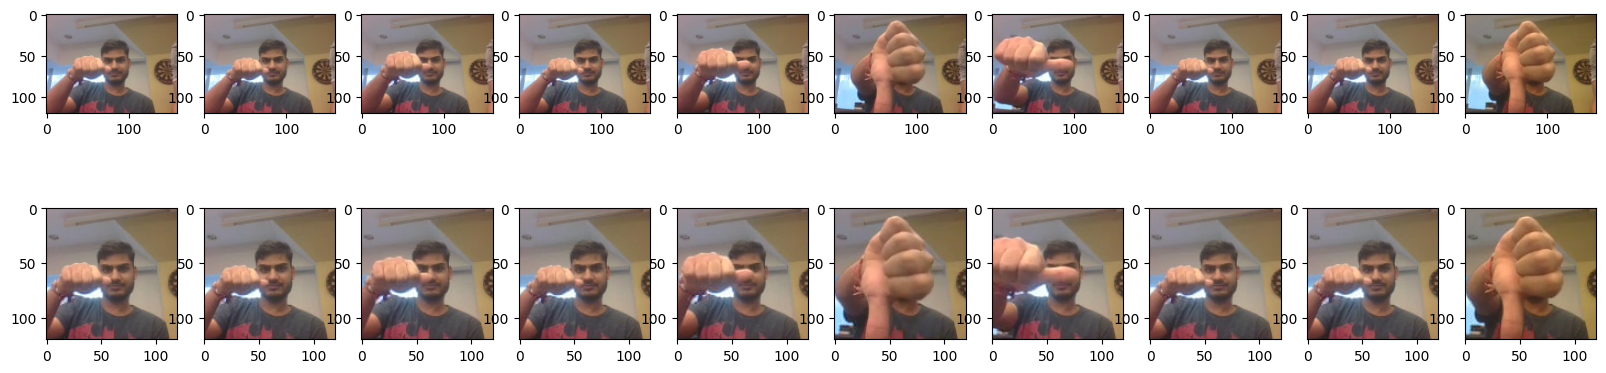

In [50]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmentation = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D, Input
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

### Experiment - 1
**Conv3D**

In [44]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.001) #write your optimizer

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

# Summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 8, 118, 118,    │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 6, 116, 116,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 3, 58, 58, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 1, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 1, 26, 26, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 13, 13, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,453 (2.72 MB)

 Trainable params: 710,533 (2.71 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [45]:
train_generator = generator(train_path, train_doc, 32, is_train = True, augmentation = enable_augmentation)
val_generator = generator(val_path, val_doc, 32)

In [46]:
model_name = 'model_init_1' + '_' + str(curr_dt_time).replace(' ','_').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.3600 - categorical_accuracy: 0.3600 - loss: 1.8874 
Epoch 1: val_loss improved from inf to 1.85985, saving model to model_init_1_2024-12-02_13_27_49.477863/model-00001-1.51640-0.40923-1.85985-0.17969.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 600s 28s/step - accuracy: 0.3622 - categorical_accuracy: 0.3622 - loss: 1.8706 - val_accuracy: 0.1797 - val_categorical_accuracy: 0.1797 - val_loss: 1.8599 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5363 - categorical_accuracy: 0.5363 - loss: 1.0815 
Epoch 2: val_loss improved from 1.85985 to 1.64226, saving model to model_init_1_2024-12-02_13_27_49.477863/model-00002-1.10911-0.52083-1.64226-0.18750.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 593s 28s/step - accuracy: 0.5356 - categorical_accuracy: 0.5356 - loss: 1.0828 - val_accuracy: 0.1875 - val_categorical_accuracy: 0.1875 - val_loss: 1.6423 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━

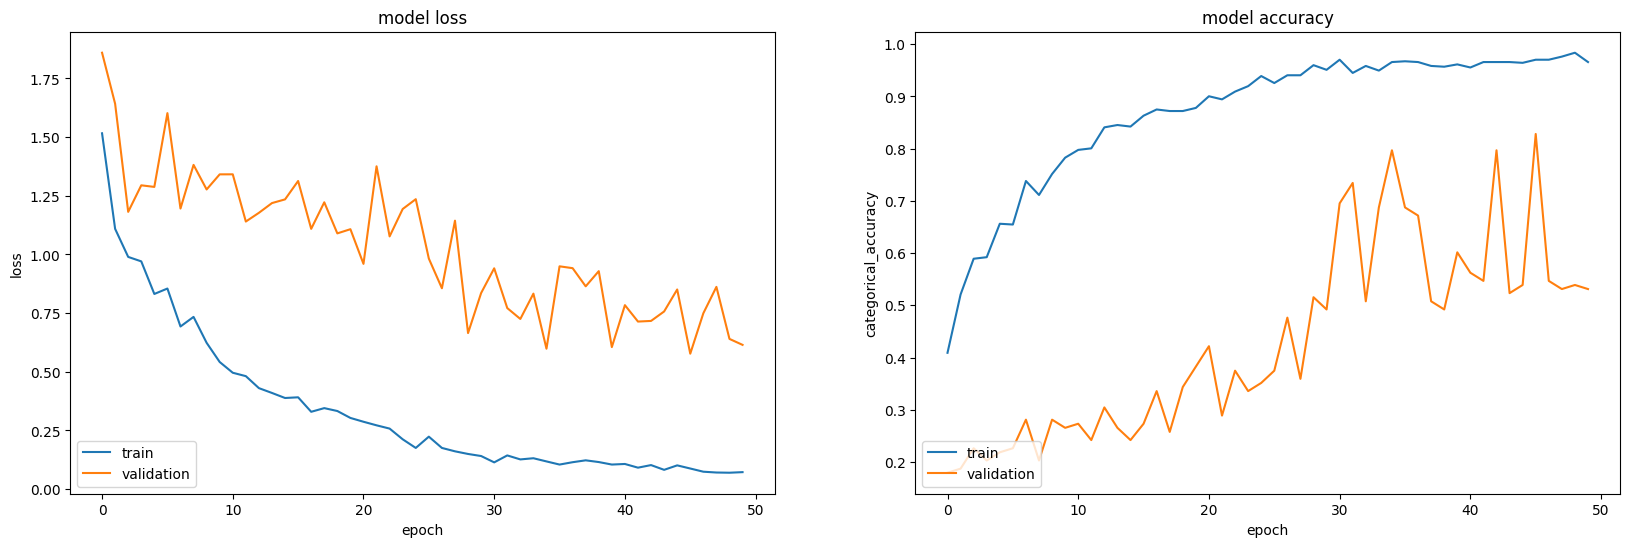

In [49]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Experiment - 2 (Final)
**TimeDistributed Conv2D + Dense**

In [18]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

# Summary of the model
model.summary()

2024-12-02 13:27:56.930354: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-02 13:27:56.930445: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: abt-lap
2024-12-02 13:27:56.930480: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: abt-lap
2024-12-02 13:27:56.930751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-02 13:27:56.930847: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-02 13:27:56.930877: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 59, 59, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 57, 57, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 26, 26,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 13, 13,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 13, 13,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,477 (505.77 KB)

 Trainable params: 128,517 (502.02 KB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
train_generator = generator(train_path, train_doc, 32, is_train = True, augmentation = enable_augmentation)
val_generator = generator(val_path, val_doc, 32)

In [25]:
model_name = 'model_init_3' + '_' + str(curr_dt_time).replace(' ','_').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3311 - categorical_accuracy: 0.3311 - loss: 2.0524
Epoch 1: val_loss improved from inf to 25.35770, saving model to model_init_3_2024-11-30_21_45_01.892756/model-00001-1.77824-0.38095-25.35770-0.17969.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3334 - categorical_accuracy: 0.3334 - loss: 2.0400 - val_accuracy: 0.1797 - val_categorical_accuracy: 0.1797 - val_loss: 25.3577 - learning_rate: 0.0100
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5016 - categorical_accuracy: 0.5016 - loss: 1.1948
Epoch 2: val_loss improved from 25.35770 to 17.52588, saving model to model_init_3_2024-11-30_21_45_01.892756/model-00002-1.19800-0.48958-17.52588-0.17969.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5011 - categorical_accuracy: 0.5011 - loss: 1.1949 - val_accuracy: 0.1797 - val_categorical_accuracy: 0.1797 - val_loss: 17.5259 - learning_rate: 0.0100
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━

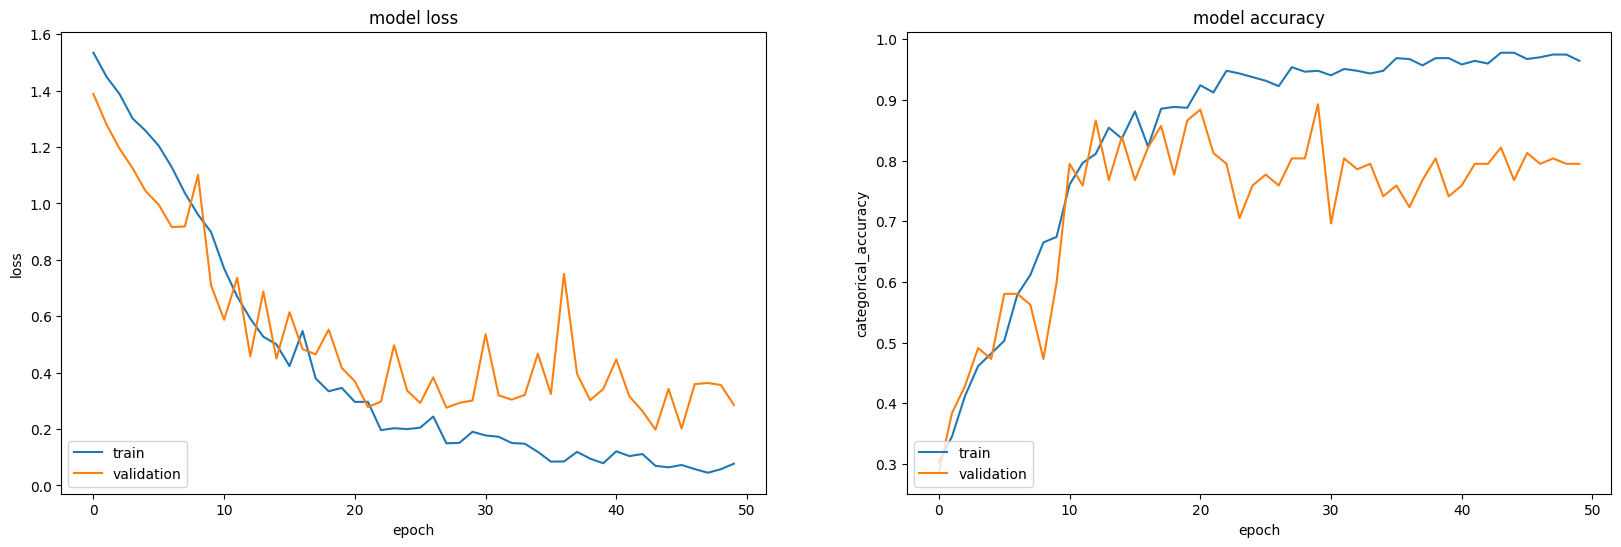

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Experiment - 3
**TimeDistributed + ConvLSTM2D**

In [15]:

model = Sequential()

# TimeDistributed Conv2D layers for spatial feature extraction
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# ConvLSTM2D for temporal sequence modeling
model.add(ConvLSTM2D(64, kernel_size=(3, 3), return_sequences=False, activation='relu'))
model.add(BatchNormalization())

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layers for Classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Regularization
model.add(Dense(5, activation='softmax'))  # Output layer for 5-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, 10, 120, 120,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 120, 120,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 60, 60, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 60, 60, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 60, 60, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 10, 30, 30, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 10, 30, 30, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 10, 15, 15, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 13, 13, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,357 (1.28 MB)

 Trainable params: 336,005 (1.28 MB)

 Non-trainable params: 352 (1.38 KB)

In [16]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init_5' + '_' + str(curr_dt_time).replace(' ','_').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-3, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2678 - categorical_accuracy: 0.2678 - loss: 1.5723
Epoch 1: val_loss improved from inf to 5.01568, saving model to model_init_5_2024-12-03_14_12_11.628029/model-00001-1.51899-0.29613-5.01568-0.16406.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 223s 10s/step - accuracy: 0.2691 - categorical_accuracy: 0.2691 - loss: 1.5699 - val_accuracy: 0.1641 - val_categorical_accuracy: 0.1641 - val_loss: 5.0157 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4237 - categorical_accuracy: 0.4237 - loss: 1.4250 
Epoch 2: val_loss improved from 5.01568 to 1.40763, saving model to model_init_5_2024-12-03_14_12_11.628029/model-00002-1.39138-0.41964-1.40763-0.30469.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 220s 10s/step - accuracy: 0.4235 - categorical_accuracy: 0.4235 - loss: 1.4235 - val_accuracy: 0.3047 - val_categorical_accuracy: 0.3047 - val_loss: 1.4076 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━

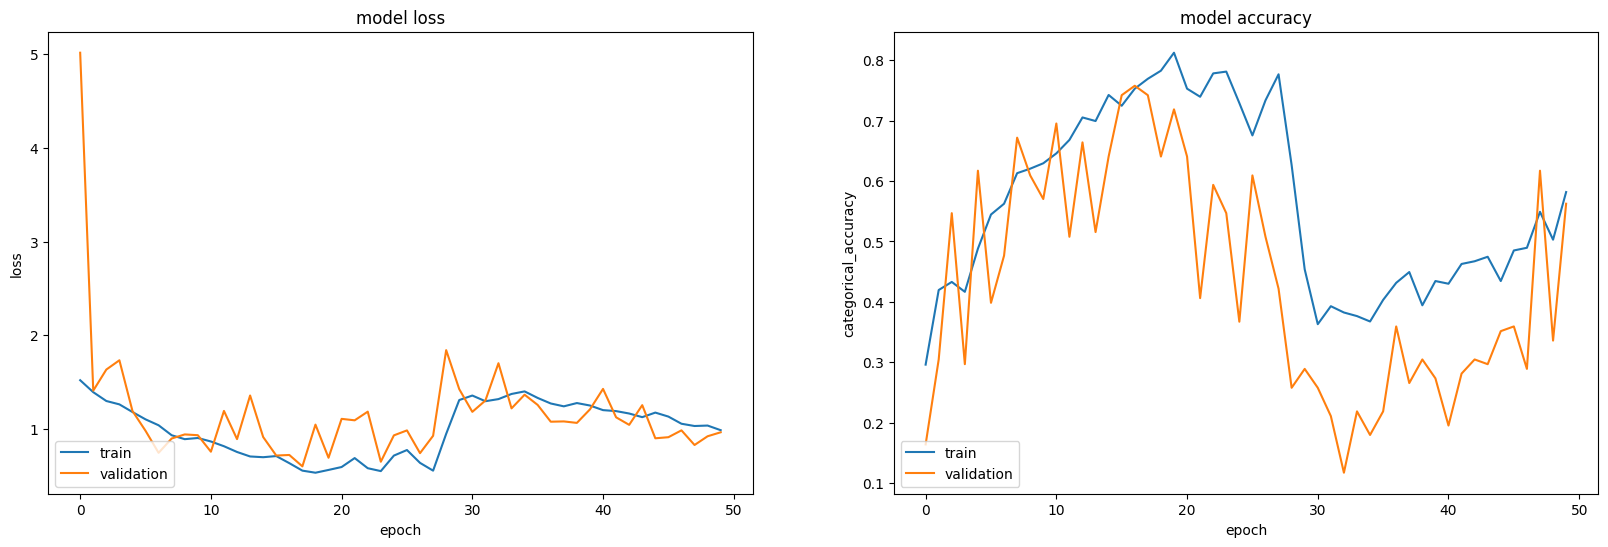

In [20]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')